**Disclaimer** This Notebook assumes that it is located within an specific ARC (https://git.nfdi4plants.org/zimmer/ChlororsColdAcclimation) at ./workflows/scripts. Please contact zimmer@csbiology to get access to the ARC. In the future this file will not rely on external data and reference data located in this repo.

In [67]:
// Currently not working
// #r "nuget: arcIO.NET, 0.1.0-preview.6"
// Fallback to:
#r "nuget: arcIO.NET, 0.0.6"
#r "nuget: ISADotNet.QueryModel, 0.7.0-preview.6"

open ISADotNet
open ISADotNet.QueryModel

Installed Packages arcIO.NET, 0.0.6 ISADotNet.QueryModel, 0.7.0-preview.6

In order to get started we use arcIO.NET to read the investigation file of the ARC. Then we call QueryModel.QInvestigation.fromInvestigation. This function creates a QInvestigation. This object is defined in ISADotNet Querymodel and our entry point to access metadata stored in the ARC.

In [68]:
let arcPath = __SOURCE_DIRECTORY__ + @"\..\..\"

let qi = 
    arcIO.NET.Investigation.fromArcFolder arcPath
    |> QueryModel.QInvestigation.fromInvestigation


For example we can have a look at all protocol sheets stored in any of the study or assay files linked to the investigation.

In [69]:
qi.ProtocolNames

[ PlantGrowth, ProteinExtraction, PSM_DDA_FragPipe_TempColFile, PSM_DDA_FragPipe_NoNorm_TempCol, PSM_Dia_FragPipeDDAlib, PSM_Dia_FragPipePrositLib, ProteomicsSamplePrep, PeptideMS, PSM_DDA_FragPipe_NoNorm_lfq ]

Here, the protocols PlantGrowth is placed in an study sheet located at ./studies/ChlorosColdAcclimationStudy.
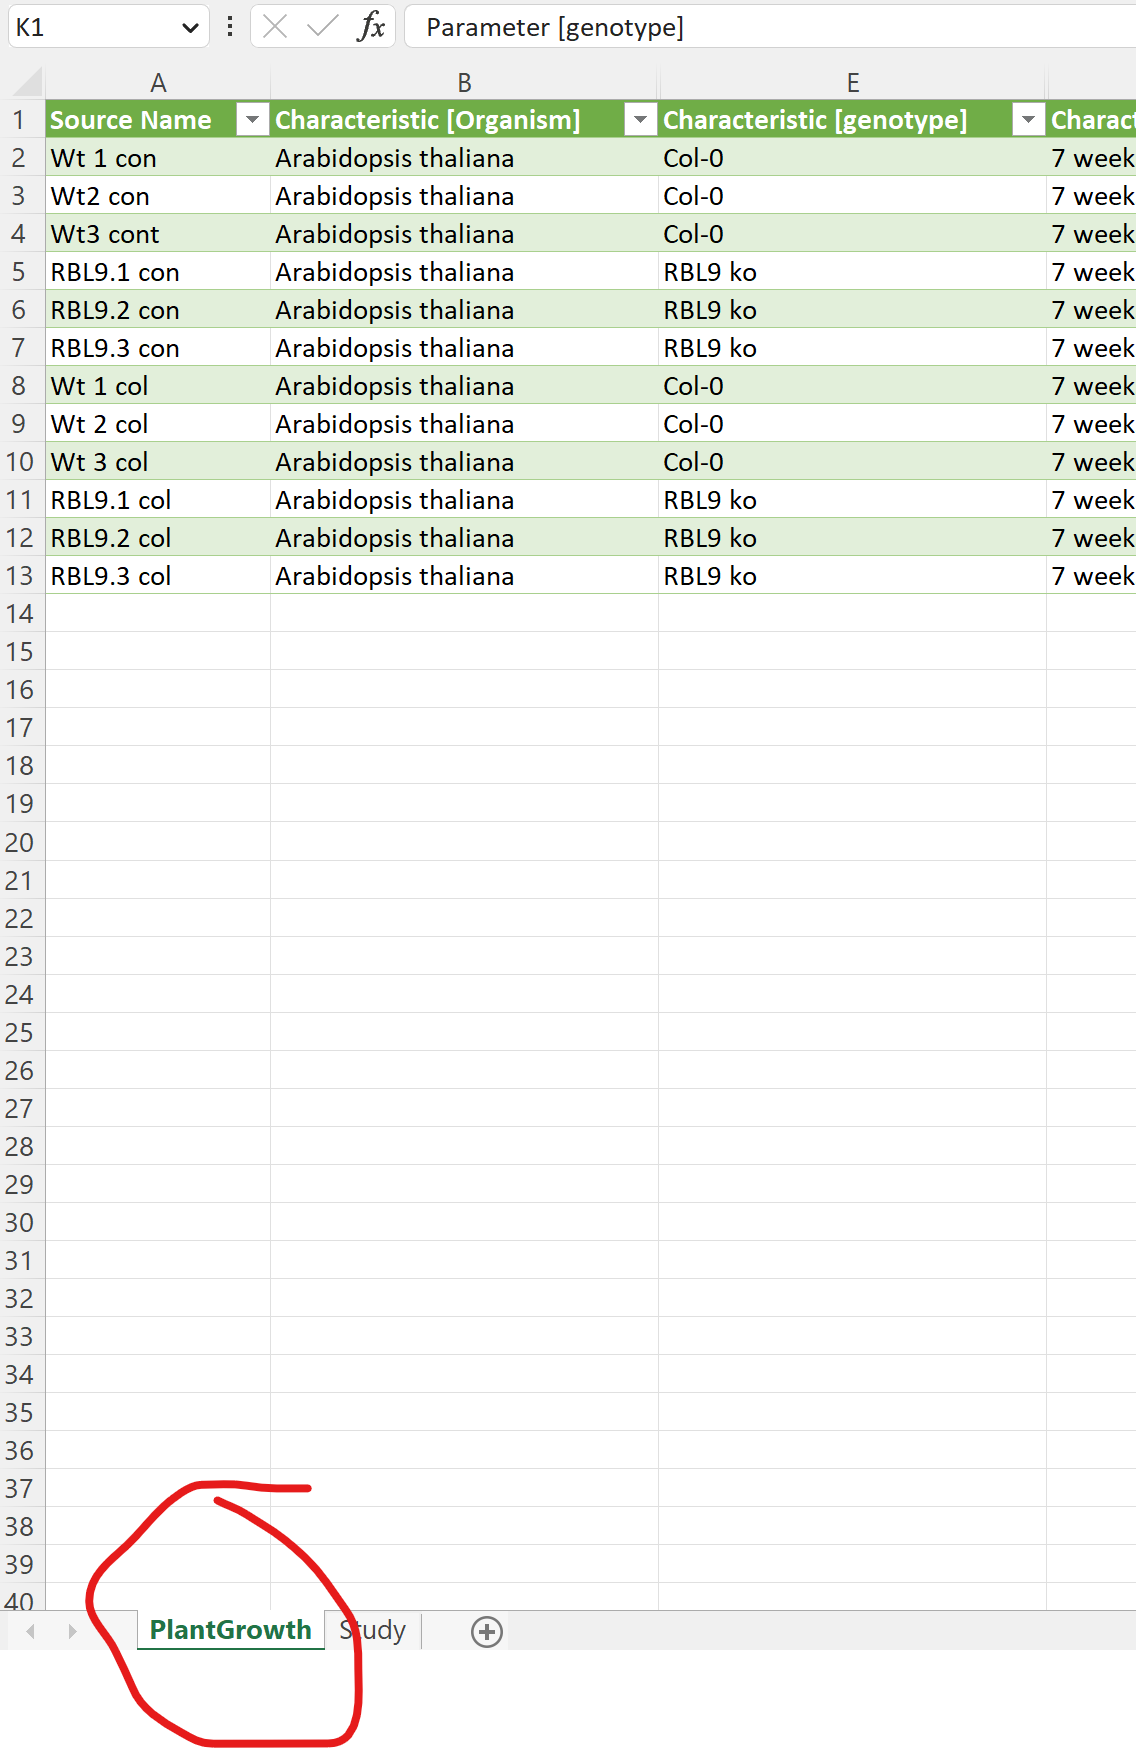


Ok. When do we need Metadata? Normally if we analyze data created by experimentalists. Say we want to analyze data which is the result of a certain assay sheet. In this case the sheet "PSM_DDA_FragPipe_TempColFile" located in the assay"assays\PSM_DDA_FragPipe".

First we get the names of the derived data files in the assay.xlsx:

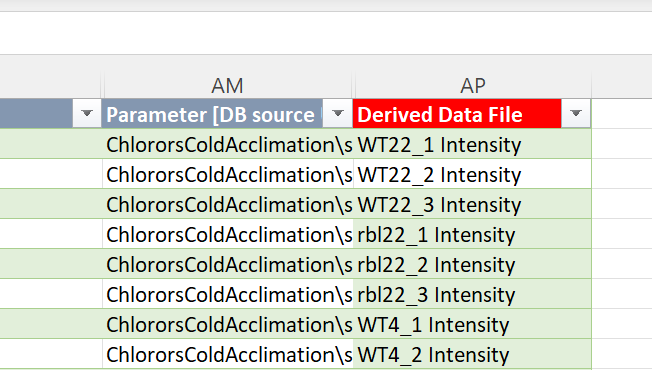

In [70]:

let resultNames = 
    qi.Protocol("PSM_DDA_FragPipe_TempColFile").OutputNames
    |> Set.ofSeq

resultNames


[ WT22_1 Intensity, WT22_2 Intensity, WT22_3 Intensity, WT4_1 Intensity, WT4_2 Intensity, WT4_3 Intensity, rbl22_1 Intensity, rbl22_2 Intensity, rbl22_3 Intensity, rbl4_1 Intensity, rbl4_2 Intensity, rbl4_3 Intensity ]

Then, we access the collection of QNodes present in the whole investigation and search for the QNodes that correspond to said data files:

In [101]:
let allSamples =         
    qi.Nodes 
    |> Seq.filter (fun x -> resultNames.Contains(x.Name))
    |> List.ofSeq


Now we can check the names of the QNodes:

In [102]:
allSamples
|> List.map (fun x -> x.Name)

[ WT22_1 Intensity, WT22_2 Intensity, WT22_3 Intensity, rbl22_1 Intensity, rbl22_2 Intensity, rbl22_3 Intensity, WT4_1 Intensity, WT4_2 Intensity, WT4_3 Intensity, rbl4_1 Intensity, rbl4_2 Intensity, rbl4_3 Intensity ]

and they correspond to the values in the assay sheet:

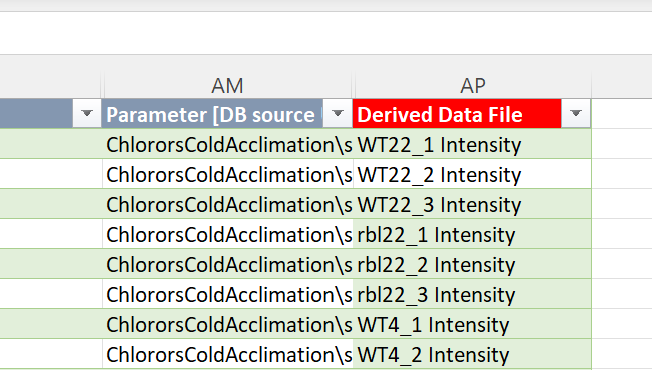


Here is the nice thing about QNodes. Each QNode represents a sample and through the Querymodel each QNode is linked to all samples upstream of that node (sources) and downstream (samples). Moreover, they are also linked to all the metadata values linked to those sources and samples.

Thus, we can use the QInvestigation object to query for information stored in columns of a specific ISA sheet. Here, we define a function "getBioRep" that given a QNode traverses the sequence of linked sources till it ariives at the protocol "Plantgrowth". Then it returns the value stored in a parameter column with the name "biological replicate".

In [103]:
let getBioRep (fN:QNode) = 
    match qi.ValuesOf(fN,ProtocolName = "PlantGrowth").WithName("biological replicate").Values.Head with
    | QueryModel.ISAValue.Parameter x -> x.Value.Value.AsString 
    | _ -> failwith "no biorep please add"

This pattern can be used to retrieve all kinds of meta data such as characteristics or other parameters:

In [104]:
let getGenotype (fN:QNode) = 
    match qi.ValuesOf(fN,ProtocolName = "PlantGrowth").WithName("genotype").Values.Head with
    | QueryModel.ISAValue.Characteristic x -> x.Value.Value.AsString 
    | _ -> failwith "no genotype please add"


let getTemp (fN:QNode) = 
    match qi.ValuesOf(fN,ProtocolName = "PlantGrowth").WithName("abiotic plant exposure").Values.Head with
    | QueryModel.ISAValue.Parameter x -> x.Value.Value.AsString//x.Value.Value.AsStringfN.Name,x.Value.Value.AsString 
    | _ -> failwith "no genotype please add"

In [105]:
allSamples
|> List.map (fun x -> x.Name,getBioRep x)

index value 0 (WT22_1 Intensity, 1) Item1 WT22_1 Intensity Item2 1 1 (WT22_2 Intensity, 2) Item1 WT22_2 Intensity Item2 2 2 (WT22_3 Intensity, 3) Item1 WT22_3 Intensity Item2 3 3 (rbl22_1 Intensity, 1) Item1 rbl22_1 Intensity Item2 1 4 (rbl22_2 Intensity, 2) Item1 rbl22_2 Intensity Item2 2 5 (rbl22_3 Intensity, 3) Item1 rbl22_3 Intensity Item2 3 6 (WT4_1 Intensity, 1) Item1 WT4_1 Intensity Item2 1 7 (WT4_2 Intensity, 2) Item1 WT4_2 Intensity Item2 2 8 (WT4_3 Intensity, 3) Item1 WT4_3 Intensity Item2 3 9 (rbl4_1 Intensity, 1) Item1 rbl4_1 Intensity Item2 1 10 (rbl4_2 Intensity, 2) Item1 rbl4_2 Intensity Item2 2 11 (rbl4_3 Intensity, 3) Item1 rbl4_3 Intensity Item2 3

In [106]:
allSamples
|> List.map (fun x -> x.Name,getGenotype x)

index value 0 (WT22_1 Intensity, Col-0) Item1 WT22_1 Intensity Item2 Col-0 1 (WT22_2 Intensity, Col-0) Item1 WT22_2 Intensity Item2 Col-0 2 (WT22_3 Intensity, Col-0) Item1 WT22_3 Intensity Item2 Col-0 3 (rbl22_1 Intensity, RBL9 ko) Item1 rbl22_1 Intensity Item2 RBL9 ko 4 (rbl22_2 Intensity, RBL9 ko) Item1 rbl22_2 Intensity Item2 RBL9 ko 5 (rbl22_3 Intensity, RBL9 ko) Item1 rbl22_3 Intensity Item2 RBL9 ko 6 (WT4_1 Intensity, Col-0) Item1 WT4_1 Intensity Item2 Col-0 7 (WT4_2 Intensity, Col-0) Item1 WT4_2 Intensity Item2 Col-0 8 (WT4_3 Intensity, Col-0) Item1 WT4_3 Intensity Item2 Col-0 9 (rbl4_1 Intensity, RBL9 ko) Item1 rbl4_1 Intensity Item2 RBL9 ko 10 (rbl4_2 Intensity, RBL9 ko) Item1 rbl4_2 Intensity Item2 RBL9 ko 11 (rbl4_3 Intensity, RBL9 ko) Item1 rbl4_3 Intensity Item2 RBL9 ko

In [107]:
allSamples
|> List.map (fun x -> x.Name,getTemp x)

index value 0 (WT22_1 Intensity, no) Item1 WT22_1 Intensity Item2 no 1 (WT22_2 Intensity, no) Item1 WT22_2 Intensity Item2 no 2 (WT22_3 Intensity, no) Item1 WT22_3 Intensity Item2 no 3 (rbl22_1 Intensity, no) Item1 rbl22_1 Intensity Item2 no 4 (rbl22_2 Intensity, no) Item1 rbl22_2 Intensity Item2 no 5 (rbl22_3 Intensity, no) Item1 rbl22_3 Intensity Item2 no 6 (WT4_1 Intensity, cold) Item1 WT4_1 Intensity Item2 cold 7 (WT4_2 Intensity, cold) Item1 WT4_2 Intensity Item2 cold 8 (WT4_3 Intensity, cold) Item1 WT4_3 Intensity Item2 cold 9 (rbl4_1 Intensity, cold) Item1 rbl4_1 Intensity Item2 cold 10 (rbl4_2 Intensity, cold) Item1 rbl4_2 Intensity Item2 cold 11 (rbl4_3 Intensity, cold) Item1 rbl4_3 Intensity Item2 cold

Of course we do not have QNodes when we analyze data. Most of the times we have to work with columnkeys. Thus we need to define a function that maps a columnkey to a Qnode:

In [115]:
let sampleNameToNode =
    allSamples
    |> List.map (fun x -> x.Name, x)
    |> Map.ofList

// eigentliche Funktion
let getQSample fN = 
    sampleNameToNode.[fN] 

// Nun bekommen wir über den ColumnKey einfach an unsere Metadaten e.g.:

In [117]:
"WT22_1 Intensity" |> getQSample |> getBioRep
"WT22_1 Intensity" |> getQSample |> getTemp

no

in practice this greatly helps to perform operations on data based on the metadata. E.g. computing means across replicates:

First we read the data:

In [122]:
#r "nuget: Deedle.Interactive, 3.0.0"
open Deedle
let data = __SOURCE_DIRECTORY__ + @"\..\..\assays\PSM_DDA_FragPipe\dataset\MS280_3ddaNormAcrRun\combined_protein.tsv"

///
let all :Frame<string,string> = 
    Frame.ReadCsv(path = data, hasHeaders=true, separators="\t")
    |> Frame.indexRows "Protein" 
    |> Frame.mapValues (fun x -> if x > 0. then x else nan)
    // |> Frame.sortRowsBy "Intensity" (fun k -> -k)
let quantValues = 
    let colsOfi = 
        all.ColumnKeys |> Seq.filter (fun x -> resultNames.Contains(x))
    all 
    |> Frame.sliceCols colsOfi   
quantValues
        

Installed Packages Deedle.Interactive, 3.0.0

rev_sp|F4J2U9|CFM3A_ARATH,->,36367.85,,,,31016.451,38667,73340.57,40188.69,66227.78,65583.86,52847.527,46016.008
rev_sp|F4JCB2|CPL5_ARATH,->,317943.56,,,,53571.066,,54746.098,54089.137,145769.89,,33995.215,46209.74
rev_sp|F4KIX0|JMJ13_ARATH,->,47876.508,,48004.305,39530.17,62865.457,122134.97,49468.33,43720.527,377507.8,50552.094,115416.164,314826.3
rev_sp|O04504|PPR27_ARATH,->,1539473.2,,1882777.8,500501.44,801528.25,1225023.2,1815966.5,1585384.8,1643852.4,1129860.1,900241.9,1164532.1
rev_sp|O49160|EIF3C_ARATH,->,41165.043,,47310.715,56461.527,59051.086,52648.26,,31219.162,66957.46,62857.395,,
:,,...,...,...,...,...,...,...,...,...,...,...,...
tr|Q9ZUJ3|Q9ZUJ3_ARATH,->,74187.38,,96507.81,,,63638.387,,18656.018,,,,
tr|Q9ZUS6|Q9ZUS6_ARATH,->,4048277.8,4015615.8,4498463,3854509.2,4524842,5927611.5,5033077.5,4295865.5,4720314,5503915.5,5130981.5,5761984
tr|Q9ZUX0|Q9ZUX0_ARATH,->,8960784,3114185.5,4558538.5,3874012,2873795.5,2756001,3610288.8,2607172,2468072,3221679,2006573.5,2171557
tr|Q9ZV08|Q9ZV08_ARATH,->,,18433.816,,,,,,,,,,
tr|Q9ZVS4|Q9ZVS4_ARATH,->,,22389.422,64060.63,58054.383,69446.18,,,,223074.52,40666.824,141756.66,379778.94


Then we group and aggregate based on metadata:

In [128]:
let res = 
    quantValues
    |> Frame.transpose
    |> Frame.groupRowsUsing (fun k s -> 
            k |> getQSample |> getGenotype, k |> getQSample |> getTemp
        )
    |> Frame.applyLevel fst Stats.mean
    |> Frame.transpose

res

rev_sp|F4J2U9|CFM3A_ARATH,->,36367.85,34841.7255,59919.013333333336,54815.79833333334
rev_sp|F4JCB2|CPL5_ARATH,->,317943.56,53571.066,84868.375,40102.47749999999
rev_sp|F4KIX0|JMJ13_ARATH,->,47940.4065,74843.53233333334,156898.88566666667,160264.85266666664
rev_sp|O04504|PPR27_ARATH,->,1711125.5,842350.9633333333,1681734.5666666664,1064878.0333333334
rev_sp|O49160|EIF3C_ARATH,->,44237.879,56053.62433333334,49088.311,62857.395
:,,...,...,...,...
tr|Q9ZUJ3|Q9ZUJ3_ARATH,->,85347.595,63638.387,18656.018,
tr|Q9ZUS6|Q9ZUS6_ARATH,->,4187452.1999999997,4768987.566666666,4683085.666666667,5465627
tr|Q9ZUX0|Q9ZUX0_ARATH,->,5544502.666666667,3167936.1666666665,2895177.6,2466603.1666666665
tr|Q9ZV08|Q9ZV08_ARATH,->,18433.816,,,
tr|Q9ZVS4|Q9ZVS4_ARATH,->,43225.026,63750.2815,223074.52,187400.808
